<a href="https://colab.research.google.com/github/danielolusipe/natural_language_processing/blob/main/09_SkimLit_nlp_milestone_project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Milestone Project 2: SkimLit 📑🔥

The purpose of this notebook is to build an NLP model to take reading medical abstracts easier.

The paper we're replacing (the source of the dataset that we'll be using) is available here: https://arxiv.org/abs/1710.06071

And reading through the paper above, we see that the model architecture that they use to achieve their best results is available here: https://arxiv.org/abs/1612

📖**Resource:** If you want to find the ground truth for this notebook (with lots of diagrams and text annotations) see the Github: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/09_SkimLit_nlp_milestone_project_2.ipynb

### Confirm access to a GPU

In [1]:
! nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-845ff364-8e2f-89f7-16d4-38e70e63c569)


### Get data

Since we'll be replicating the paper above (PubMed 200k RCT), let's download the dataset they used.

We can do so from the authors Github: https://github.com/Franck-Dernoncourt/pubmed-rct

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.
Checking out files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
# Check what files are in the PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [4]:
# Start our experiment using the 20k dataset with numbers replaced by "@" sign 
data_dir="/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [5]:
# Check all of the fienames in the target directory
import os 
filenames=[data_dir+filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

### Preprocess data

Now we've got some text data, it's time to become one with the it.

And one of the best ways to become one with the data is to...

> Visualize, visualize, visualize

So with that in mind, let's write a funtion to read in all of the lines of a target text file.

In [6]:
# Create function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of text asa list.

  Args: 
    filename: a string containing the target filepath.
 
  Returns:
  A list of strings with one string per line from the target filename.
  """
  with open(filename,"r") as f:
    return f.readlines()

In [7]:
# Let's read in the training lines 
train_lines=get_lines(data_dir+"train.txt") # read the lines with the training file
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [8]:
len(train_lines)

210040

Let's think about how we want our data to look...

How I think our data would be best represented...

```
[{'line_number':0,
  'target': 'BACKGROUND',
  'text': "Emotional eating is associated with overeating and the development of obesity .\n"
  'total_lines':11},
...]
```

In [9]:
def preprocess_text_with_line_numbers(filename):
  """
  Return a list of dictionaries of abstract line data

  Takes in filename, reads it contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence
  number the target line is.
  """
  input_lines=get_lines(filename) # get all lines from filenames
  abstract_lines="" # create an empty abstract
  abstract_samples=[] # create an empty list of abstracts

  # Loop through line in the target file
  for line in input_lines:
    if line.startswith("###"): # check to see if the line is an ID line
      abstract_id=line
      abstract_lines="" # reset the abstract string if the line is an ID line
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split=abstract_lines.splitlines() # split abstract into seperate lines

      # Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number,abstract_line in enumerate(abstract_line_split):
        line_data={} # create an empty dictionary for each line
        target_text_split=abstract_line.split("\t") # split target label from text
        line_data["target"]=target_text_split[0] # get target label
        line_data["text"]=target_text_split[1].lower() # get target text and lower it
        line_data["line_number"]=abstract_line_number # what number line does the line appear in the abstract
        line_data["total_lines"]=len(abstract_line_split)-1 # how many total lines are there in the target abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above condition aren't fulfilled, the line contains a labelled sentence
      abstract_lines+=line

  return abstract_samples

In [10]:
# Get data from file and preprocess it 
%%time 
train_samples=preprocess_text_with_line_numbers(data_dir+"train.txt")
val_samples=preprocess_text_with_line_numbers(data_dir+"dev.txt") # dev is another name for validation dataset
test_samples=preprocess_text_with_line_numbers(data_dir+"test.txt")
len(train_samples),len(val_samples),len(test_samples)

CPU times: user 744 ms, sys: 117 ms, total: 861 ms
Wall time: 1.26 s


(180040, 30212, 30135)

In [11]:
# Check the first abstract of our training data
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

Now that our data is in the format of a list of dictionaries, how about we turn it into a DataFrame to further visualize it?

In [12]:
import pandas as pd
train_df=pd.DataFrame(train_samples)
val_df=pd.DataFrame(val_samples)
test_df=pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [13]:
# Disttibution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

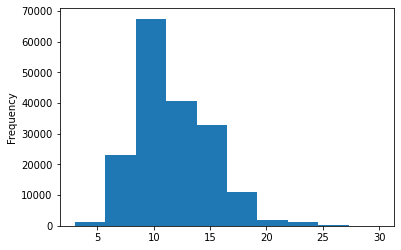

In [14]:
# Let's check the length of different lines
train_df.total_lines.plot.hist();

### Get list of sentences 

In [15]:
# Convert abstract text lines into lists
train_sentences=train_df["text"].tolist()
val_sentences=val_df["text"].tolist()
test_sentences=test_df["text"].tolist()
len(train_sentences),len(val_sentences),len(test_sentences)

(180040, 30212, 30135)

In [16]:
# View the first 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

### Make numeric labels (ML model requires numeric labels)

In [17]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder=OneHotEncoder(sparse=False) # we want non-sparse matrix
train_labels_one_hot=one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot=one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot=one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))

# Check what one hot encoded labels look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label encode labels

In [18]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder=LabelEncoder()
train_labels_encoded=label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded=label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded=label_encoder.transform(test_df["target"].to_numpy())

# Checkk what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [19]:
# Get class names and number of classes from LabelEncoder instance
num_classes=len(label_encoder.classes_)
class_names=label_encoder.classes_
num_classes,class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

### Starting a series of modelling experiments...

As usual, we're going yo be trying out a bunch of different models and seeing which one works best.

And as alwats, we're going to start with a baseline (TF-IDF Multinomial Naive Bayes classifier).

### Model 0: Getting a baseline

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0=Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [21]:
# Evaluating baseline model on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [22]:
# Make predictions using our baseline model
baseline_preds=model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

### Download helper function script 

In the previous module, we wrote a function to compare predictions across different metrics (accuracy, precision, recall and f1) and rather than rewriting it here, let's download it from our helper function script: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py

In [23]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-09-14 23:20:58--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-09-14 23:20:58 (63.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [24]:
from helper_functions import calculate_results

In [25]:
# Calculate baseline results
baseline_results=calculate_results(y_true=val_labels_encoded,
                                   y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

### Preparing our data (the text) for deep sequence model

Before we start building deeper models, we've got to create vectorization and embedding layers.

In [26]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [27]:
# How long is each sentences on average
sent_lens=[len(sentences.split()) for sentences in train_sentences]
avg_sent_lens=np.mean(sent_lens)
avg_sent_lens

26.338269273494777

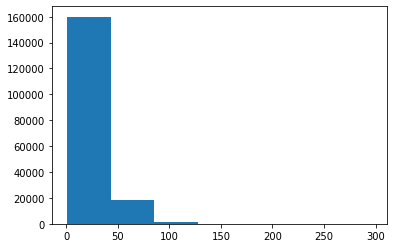

In [28]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens,bins=7);

In [29]:
# How long of a sentence length covers 95% of examples?
output_seq_len=int(np.percentile(sent_lens,95))
output_seq_len

55

In [30]:
# Maximum sequence length in the training set 
max(sent_lens)

296

### Create text vectorizer layer

We want to make a layer which map our texts from words to numbers

In [31]:
# How many words are in our vocab? (taken from table 2 in: https://arxiv.org/pdf/1710.06071.pdf)
max_tokens=68000

In [32]:
# Create text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of words in vocabulary
                                    output_sequence_length=55) # desired output length of vectorized sequences

In [33]:
# Adapt text vectorization to training sentences
text_vectorizer.adapt(train_sentences)

In [34]:
# Test out text vectorizer on random sentences
import random 
target_sentence=random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text:
interventions with wbe , oligofructose or placebo for @ wk ( week @ : @ g/day ; week @ : @ g/day ) were separated by @-wk wash-out periods .

Length of text: 30

Vectorized text: [[  265     7 11774 13826    16    48    11  1183    89  2290    89  2290
      9  2652    22  1183  1611  1242     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [35]:
# How many words in our training vocabulary
rct_20k_text_vocab=text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Last common word in the vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Last common word in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [36]:
# Get the config of out text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

### Create custom text embedding

In [37]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # length of vocabulary
                               output_dim=128, # Note: different embedding sizes result in drastically different numbers of parameters to train
                               # Use masking to handle variable sequence lengths (save space)
                               mask_zero=True,
                               name="token_embedding") 

In [38]:
# Show sample embedding
print(f"Sentence before vectorization:\n {target_sentence}\n")
vectorized_sentence=text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding:\n {vectorized_sentence}\n")
embedded_sentence=token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
 interventions with wbe , oligofructose or placebo for @ wk ( week @ : @ g/day ; week @ : @ g/day ) were separated by @-wk wash-out periods .

Sentence after vectorization (before embedding:
 [[  265     7 11774 13826    16    48    11  1183    89  2290    89  2290
      9  2652    22  1183  1611  1242     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
 [[[ 0.01737071 -0.0098828   0.04571826 ... -0.02954892 -0.03233897
    0.00290191]
  [ 0.00949549 -0.03948503 -0.03758691 ...  0.02958607  0.03993602
    0.01684108]
  [-0.02558848 -0.03972539  0.02065207 ... -0.03200863 -0.03747827
    0.02093882]
  ...
  [-0.01281669  0.04493066 -0.00453621 ...  0.0280465  -0.04162651
   -0.03551736]
  [-0.01281669  0.04493066 -0.00453621 ...  0.0280465  -0.04162651
  

### Creating datasets (making sure our data loads as fast as possible)

We're going to setup our data to run as fast as possible with the TensorFlow tf.data API, many of the steps here are discussed at length in these two resources:
* https://www.tensorflow.org/guide/data_performance
* https://www.tensorflow.org/guide/data

In [39]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [40]:
# Take the TensorSliceDataset's and turn them into prefetched batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### Model 1: Conv1D with token embeddings

In [41]:
# Create 1D convolutional model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss="categorical_crossentropy", # if your labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [42]:
# Get summary of Conv1D model
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [43]:
# Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), # only fit on 10% of batches for faster training time
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset))) # only validate on 10% of batche

Epoch 1/3
562/562 [==============================] - 16s 9ms/step - loss: 0.9052 - accuracy: 0.6450 - val_loss: 0.6806 - val_accuracy: 0.7427
Epoch 2/3
562/562 [==============================] - 5s 8ms/step - loss: 0.6563 - accuracy: 0.7571 - val_loss: 0.6285 - val_accuracy: 0.7723
Epoch 3/3
562/562 [==============================] - 5s 8ms/step - loss: 0.6179 - accuracy: 0.7721 - val_loss: 0.5978 - val_accuracy: 0.7826


In [44]:
# Evaluate on whole validation dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5991 - accuracy: 0.7860


[0.5991478562355042, 0.786045253276825]

In [45]:
# Make predictions (our model predicts prediction probabilities for each class)
model_1_pred_probs=model_1.predict(valid_dataset)
model_1_pred_probs,model_1_pred_probs.shape

(array([[4.57407743e-01, 1.57911062e-01, 6.20736927e-02, 2.95118451e-01,
         2.74890065e-02],
        [4.55461264e-01, 2.75518090e-01, 1.67301018e-02, 2.43097782e-01,
         9.19271540e-03],
        [1.40673861e-01, 4.70892340e-03, 2.01914692e-03, 8.52557242e-01,
         4.08958404e-05],
        ...,
        [6.63980154e-06, 7.01617275e-04, 7.16876413e-04, 2.87922808e-06,
         9.98571992e-01],
        [4.90493886e-02, 4.32687551e-01, 1.03871375e-01, 5.48291132e-02,
         3.59562576e-01],
        [1.55407250e-01, 6.92309141e-01, 4.16496359e-02, 5.15618771e-02,
         5.90720661e-02]], dtype=float32), (30212, 5))

In [46]:
# Convert pred probs to classes
model_1_preds=tf.argmax(model_1_pred_probs,axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [47]:
# Calculate model_1 results
model_1_results=calculate_results(y_true=val_labels_encoded,
                                  y_pred=model_1_preds)
model_1_results

{'accuracy': 78.60452800211837,
 'precision': 0.7827229097495659,
 'recall': 0.7860452800211837,
 'f1': 0.7834588236976626}

### Model 2: Feature extraction with pretrained token embeddings

Now let's use pretrained word embeddings from TensorFlow hub, more specifically the universal sentence encoder: https://tfhub.dev/google/universal-sentence-encoder/4

The paper originally use GloVe embeddings,however, we're going to stick with the later created USE pretrained embeddings

In [48]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer=hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                      trainable=False,
                                      name="universal_sentence_encoder")

In [49]:
# Test out the pretrained embedding on a random sentence
random_train_sentence=random.choice(train_sentences)
print(f"Random sentence:\n {random_train_sentence}")
use_embedded_sentence=tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]}\n")
print(f"Length of sentence embedding:{len(use_embedded_sentence[0])}")

Random sentence:
 at a median follow-up of @ years , the study excluded a difference of more than @ % in @-year ffs and more than @ % in @-year os between abvd and stanford v ( @-year ffs : @ % v @ % ; hr , @ ; @ % ci , @ to @ ; p = @ ; @-year os : @ % v @ % ; hr , @ ; @ % ci , @ to @ ; p = @ ) .
Sentence after embedding:
[-0.01830795 -0.08214355 -0.07294997 -0.00698206 -0.02897879 -0.07171562
  0.0066079  -0.04149161  0.07630464  0.01700984 -0.02707956  0.05378034
 -0.03739047  0.01528823 -0.05368687  0.00183244 -0.05034979  0.02913821
  0.06083727 -0.08588205  0.05918181 -0.05226211  0.02942888  0.06899765
  0.01078754  0.07861599 -0.00309689 -0.05588807 -0.01936148 -0.03251323]

Length of sentence embedding:512


### Building and fitting an NLP feature extraction model using pretrained embeddings TensorFLow Hub

In [50]:
# Define feature extraction model using TF Hub layers
inputs=layers.Input(shape=[],dtype=tf.string)
pretrained_embedding=tf_hub_embedding_layer(inputs) # tokenize text and create embedding of each sequence (512 long vector)
x=layers.Dense(128,activation="relu")(pretrained_embedding)
# Note: you could add more layers here if you wanted to
outputs=layers.Dense(num_classes,activation="softmax")(x) # Create the output layer
model_2=tf.keras.Model(inputs=inputs,
                       outputs=outputs,
                       name="model_2_USE_feature_extractor")

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics="accuracy")

In [51]:
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [52]:
# Fit model_2 to the data
history_model_2=model_2.fit(train_dataset,
                            epochs=3,
                            steps_per_epoch=int(0.1*len(train_dataset)),
                            validation_data=valid_dataset,
                            validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 9s 13ms/step - loss: 0.9184 - accuracy: 0.6519 - val_loss: 0.7963 - val_accuracy: 0.6898
Epoch 2/3
562/562 [==============================] - 7s 12ms/step - loss: 0.7687 - accuracy: 0.7025 - val_loss: 0.7548 - val_accuracy: 0.7031
Epoch 3/3
562/562 [==============================] - 7s 12ms/step - loss: 0.7509 - accuracy: 0.7113 - val_loss: 0.7380 - val_accuracy: 0.7148


In [53]:
# Evaluate on the whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 10s 10ms/step - loss: 0.7392 - accuracy: 0.7143


[0.7391684055328369, 0.7142525911331177]

In [54]:
# Make preditions with feature extraction model
model_2_pred_probs=model_2.predict(valid_dataset)
model_2_pred_probs

array([[0.43828306, 0.35285893, 0.00268702, 0.19865328, 0.00751769],
       [0.3801606 , 0.46235198, 0.00378323, 0.15031052, 0.00339371],
       [0.21319865, 0.10744116, 0.01703043, 0.63044006, 0.03188968],
       ...,
       [0.00192764, 0.00624405, 0.05864386, 0.00098413, 0.9322003 ],
       [0.0035828 , 0.05181125, 0.19959162, 0.00172635, 0.7432879 ],
       [0.15645869, 0.24714023, 0.5227439 , 0.00858555, 0.06507163]],
      dtype=float32)

In [55]:
# Convert the prediction probabilities found with feature extraction model to labels
model_2_preds=tf.argmax(model_2_pred_probs,axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [56]:
# Calculate results from TF Hub pretrained embeddings results on val set 
model_2_results=calculate_results(y_true=val_labels_encoded,
                                  y_pred=model_2_preds)
model_2_results

{'accuracy': 71.42526148550245,
 'precision': 0.7147305281939991,
 'recall': 0.7142526148550244,
 'f1': 0.7113392273865952}

### Model 3: Conv1D with character embeddings

The paper which we're replicating states they uses a combination of token and character-level embedddings.

Previously we've token-level embeddings but we'll need to do similar steps for characters if we want to use char-level embeddings

### Creating a character-level tokenizer

In [57]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Text splitting non-character-level sequence into character
split_chars(random_train_sentence)

'a t   a   m e d i a n   f o l l o w - u p   o f   @   y e a r s   ,   t h e   s t u d y   e x c l u d e d   a   d i f f e r e n c e   o f   m o r e   t h a n   @   %   i n   @ - y e a r   f f s   a n d   m o r e   t h a n   @   %   i n   @ - y e a r   o s   b e t w e e n   a b v d   a n d   s t a n f o r d   v   (   @ - y e a r   f f s   :   @   %   v   @   %   ;   h r   ,   @   ;   @   %   c i   ,   @   t o   @   ;   p   =   @   ;   @ - y e a r   o s   :   @   %   v   @   %   ;   h r   ,   @   ;   @   %   c i   ,   @   t o   @   ;   p   =   @   )   .'

In [58]:
# Split sequence-level data splits into character-level data splits
train_chars=[split_chars(sentence) for sentence in train_sentences]
val_chars=[split_chars(sentence) for sentence in val_sentences]
test_chars=[split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [59]:
# What's the average character length?
char_lens=[len(sentence) for sentence in train_sentences]
mean_char_len=np.mean(char_lens)
mean_char_len

149.3662574983337

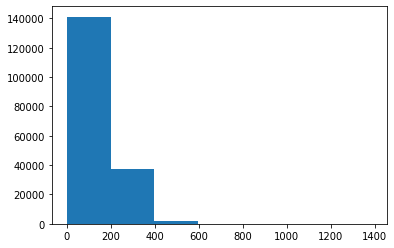

In [60]:
# Check the distribution of our sequences at a character-level
import matplotlib.pyplot as plt
plt.hist(char_lens,bins=7);

In [61]:
# Find what character length covers 95% of sequences
output_seq_char_len=int(np.percentile(char_lens,95))
output_seq_char_len

290

In [62]:
# Get all keyboard characters
import string
alphabet=string.ascii_lowercase+string.digits+string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [63]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS=len(alphabet) + 2 # add 2 for space and OOV token (OOV=out of vocab,'[UNK]')
char_vectorizer=TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                  output_sequence_length=output_seq_char_len,
                                  #standardize=None, # Set standardization to "None" if you want to leave punctuation in
                                  name="char_vectorizer")

In [64]:
# Adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)

In [65]:
# Check character vocab stats
char_vocab=char_vectorizer.get_vocabulary()
print(f"Number of different characters in charater vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common character: {char_vocab[-5:]}")

Number of different characters in charater vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common character: ['k', 'x', 'z', 'q', 'j']


In [66]:
# Test out character vectorizer
random_train_chars=random.choice(train_chars)
print(f"charified text:\n {random_train_chars}")
print(f"\nLength of random_train_chars: {len(random_train_chars.split())}")
vectorized_chars=char_vectorizer([random_train_chars])
print(f"\nVectorized chars: \n {vectorized_chars}")
print(f"Length of vectorized chars: {len(vectorized_chars[0])}")

charified text:
 t h e   e x p e r i m e n t a l   g r o u p   r e c e i v e d   s t a n d a r d   t h e r a p y   (   @   %   o f   e x e r c i s e   t i m e   )   a s s o c i a t e d   w i t h   r o b o t i c   t r a i n i n g   (   @   %   o f   e x e r c i s e   t i m e   )   .

Length of random_train_chars: 109

Vectorized chars: 
 [[ 3 13  2  2 24 14  2  8  4 15  2  6  3  5 12 18  8  7 16 14  8  2 11  2
   4 21  2 10  9  3  5  6 10  5  8 10  3 13  2  8  5 14 19  7 17  2 24  2
   8 11  4  9  2  3  4 15  2  5  9  9  7 11  4  5  3  2 10 20  4  3 13  8
   7 22  7  3  4 11  3  8  5  4  6  4  6 18  7 17  2 24  2  8 11  4  9  2
   3  4 15  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  

In [67]:
# Create char embedding layer
char_embed=layers.Embedding(input_dim=len(char_vocab), # number of different character
                            output_dim=25, # this is the size of the char embedding in the paper: https://arxiv.org/pdf/1710.06071.pdf (Figure 1)
                            mask_zero=True,
                            name="char_embed")

In [68]:
# Test out character embedding ayer
print(f"Charified text:\n {random_train_chars}\n")
char_embed_example=char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n {char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text:
 t h e   e x p e r i m e n t a l   g r o u p   r e c e i v e d   s t a n d a r d   t h e r a p y   (   @   %   o f   e x e r c i s e   t i m e   )   a s s o c i a t e d   w i t h   r o b o t i c   t r a i n i n g   (   @   %   o f   e x e r c i s e   t i m e   )   .

Embedded chars (after vectorization and embedding):
 [[[-0.02037485 -0.01953689 -0.04020143 ... -0.03567686 -0.01114647
    0.04382557]
  [ 0.01402905  0.02125713  0.03178421 ... -0.03353858 -0.0167688
   -0.02524087]
  [ 0.02489981  0.04450393 -0.00077159 ...  0.03470296  0.02290503
    0.03551844]
  ...
  [-0.01580996 -0.01095151 -0.02174423 ... -0.04038006 -0.00612115
   -0.0370001 ]
  [-0.01580996 -0.01095151 -0.02174423 ... -0.04038006 -0.00612115
   -0.0370001 ]
  [-0.01580996 -0.01095151 -0.02174423 ... -0.04038006 -0.00612115
   -0.0370001 ]]]

Character embedding shape: (1, 290, 25)


### Building a Conv1D model to fit on character embeddings

In [69]:
# Make Conv1D on Chars only
inputs=layers.Input(shape=(1,),dtype=tf.string)
char_vectors=char_vectorizer(inputs)
char_embeddings=char_embed(char_vectors)
x=layers.Conv1D(64,kernel_size=5,padding="same",activation="relu")(char_embeddings)
x=layers.GlobalMaxPooling1D()(x)
outputs=layers.Dense(num_classes,activation="softmax")(x)
model_3=tf.keras.Model(inputs=inputs,
                       outputs=outputs,
                       name="model_3_conv1d_char_embeddings")

# Compile 
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics="accuracy") 

In [70]:
# Summary
model_3.summary()

Model: "model_3_conv1d_char_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 

In [71]:
# Create char level datasets
train_char_dataset=tf.data.Dataset.from_tensor_slices((train_chars,train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset=tf.data.Dataset.from_tensor_slices((val_chars,val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset=tf.data.Dataset.from_tensor_slices((test_chars,test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [72]:
# Fit the model on chars only
model_3_history=model_3.fit(train_char_dataset,
                            steps_per_epoch=int(0.1*len(train_char_dataset)),
                            epochs=3,
                            validation_data=val_char_dataset,
                            validation_steps=int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 4s 6ms/step - loss: 1.2604 - accuracy: 0.4890 - val_loss: 1.0513 - val_accuracy: 0.5818
Epoch 2/3
562/562 [==============================] - 3s 5ms/step - loss: 1.0075 - accuracy: 0.5935 - val_loss: 0.9450 - val_accuracy: 0.6293
Epoch 3/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9219 - accuracy: 0.6386 - val_loss: 0.8757 - val_accuracy: 0.6636


In [73]:
# Make predictions with character model only
model_3_pred_probs=model_3.predict(val_char_dataset)
model_3_pred_probs

array([[0.19097584, 0.3970511 , 0.14773206, 0.19739926, 0.06684177],
       [0.25320777, 0.38147846, 0.01384366, 0.33975002, 0.01172012],
       [0.10361848, 0.29783353, 0.06087475, 0.5271687 , 0.0105045 ],
       ...,
       [0.03053413, 0.06654037, 0.13294065, 0.0438059 , 0.72617894],
       [0.02465105, 0.10315898, 0.28782773, 0.02483438, 0.5595278 ],
       [0.5613938 , 0.27482074, 0.02353206, 0.12279423, 0.0174591 ]],
      dtype=float32)

In [74]:
# Convert prediction probabilities to class labels
model_3_preds=tf.argmax(model_3_pred_probs,axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 0])>

In [75]:
# Calculate results for Conv1D model chars only
model_3_results=calculate_results(y_true=val_labels_encoded,
                                  y_pred=model_3_preds) 
model_3_results

{'accuracy': 65.55342248113332,
 'precision': 0.6478813055353903,
 'recall': 0.6555342248113333,
 'f1': 0.6478814414542033}

### Model 4: Combining pretrained token embeddings + characters embeddings (hybrid embedding layer)

1. Create a token-level embedding model (similar `model_1`)
2. Create a character-level model (similar to `model_3` with a slight modification)
3. Combine 1 & 2 with a concatenate (`layers.Concatenate`)
4. Build a series of output layers on top of 3 similar to figure 1 and section 4.2 of https://arxiv.org/pdf/1710.06071.pdf 
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output

In [76]:
# 1. Setup token inputs/model
token_inputs=layers.Input(shape=[],dtype=tf.string,name="token_input")
token_embeddings=tf_hub_embedding_layer(token_inputs)
token_outputs=layers.Dense(128,activation="relu")(token_embeddings)
token_model=tf.keras.Model(inputs=token_inputs,
                           outputs=token_outputs)

# 2. Setup char inputs/model
char_inputs=layers.Input(shape=(1,),dtype=tf.string,name="char_input")
char_vectors=char_vectorizer(char_inputs)
char_embeddings=char_embed(char_vectors)
char_bi_lstm=layers.Bidirectional(layers.LSTM(24))(char_embeddings) # bi-LSTM shown in figure 1 of https://arxiv.org/pdf/1710.06071.pdf 
char_model=tf.keras.Model(inputs=char_inputs,
                          outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat=layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                char_model.output])

# 4. Create output layers - adding in Dropout, discussed in section 4.2 of https://arxiv.org/pdf/1710.06071.pdf 
combined_dropout=layers.Dropout(0.5)(token_char_concat)
combined_dense=layers.Dense(128,activation="relu")(combined_dropout)
final_dropout=layers.Dropout(0.5)(combined_dense)
output_layer=layers.Dense(num_classes,activation="softmax")(final_dropout)

# 5. Construst model with char and token inputs
model_4=tf.keras.Model(inputs=[token_model.input,char_model.input],
                       outputs=output_layer,
                       name="model_4_token_and_char_embeddings")

In [77]:
# Get a summary of our model
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

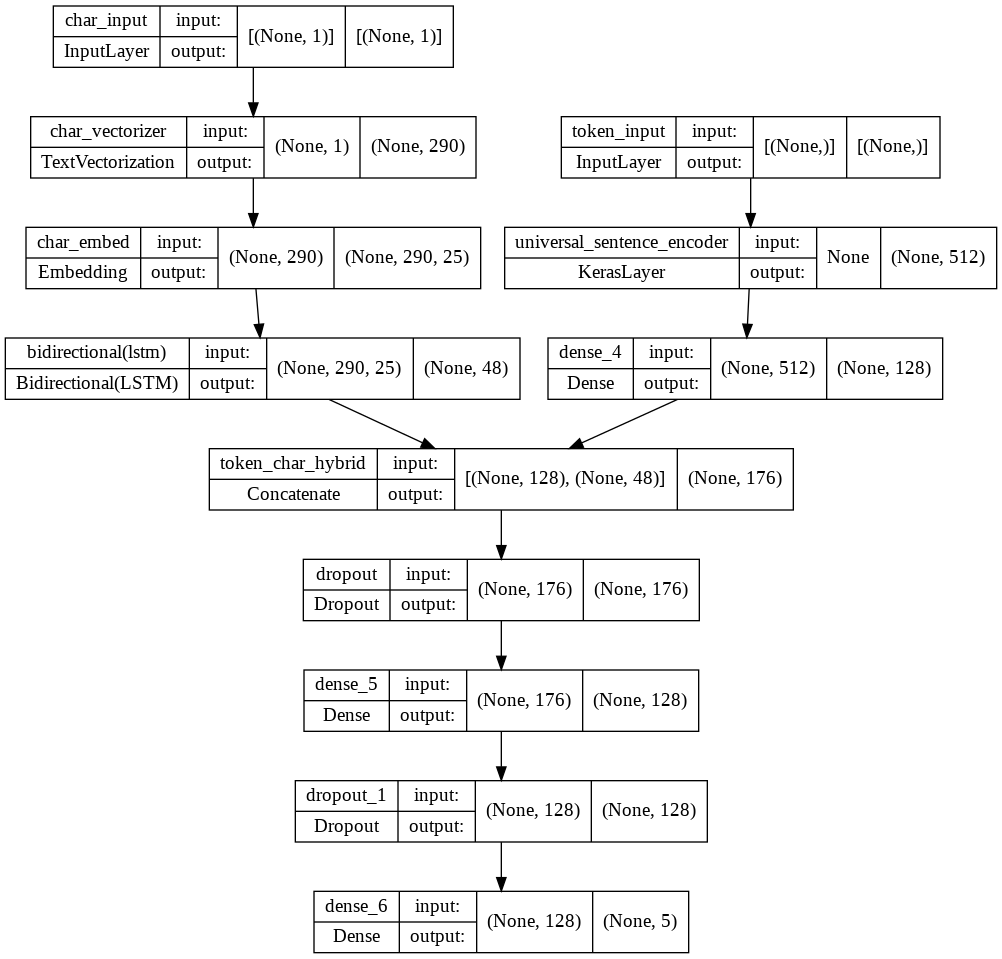

In [78]:
# plot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_4,show_shapes=True)

In [79]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), # section 4.2 of the paper says they use SGD, you might want to try this
                metrics="accuracy")

### Combining token and character data into a tf.data.Dataset

In [80]:
# Combine chars and token into a dataset
train_char_token_data=tf.data.Dataset.from_tensor_slices((train_sentences,train_chars)) # make data
train_char_token_labels=tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset=tf.data.Dataset.zip((train_char_token_data,train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset=train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [81]:
# Repeat the above steps for our validation data
val_char_token_data=tf.data.Dataset.from_tensor_slices((val_sentences,val_chars)) # make data
val_char_token_labels=tf.data.Dataset.from_tensor_slices(val_labels_one_hot) # make labels
val_char_token_dataset=tf.data.Dataset.zip((val_char_token_data,val_char_token_labels)) # combine data and labels
val_char_token_dataset=val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [82]:
# Check out our training char and token embedding dataset
train_char_token_dataset,val_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting a model on token and character-level sequences

In [83]:
# Fit the model on token and chars
history_model_4=model_4.fit(train_char_token_dataset,
                            steps_per_epoch=int(0.1*len(train_char_token_dataset)),
                            epochs=3,
                            validation_data=train_char_token_dataset,
                            validation_steps=int(0.1*len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 37s 51ms/step - loss: 0.9777 - accuracy: 0.6100 - val_loss: 0.7739 - val_accuracy: 0.7121
Epoch 2/3
562/562 [==============================] - 25s 45ms/step - loss: 0.8001 - accuracy: 0.6917 - val_loss: 0.7174 - val_accuracy: 0.7367
Epoch 3/3
562/562 [==============================] - 23s 41ms/step - loss: 0.7742 - accuracy: 0.7058 - val_loss: 0.7121 - val_accuracy: 0.7434


In [84]:
# Evaluate on the whole validation datset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 21s 22ms/step - loss: 0.6990 - accuracy: 0.7347


[0.6989938020706177, 0.7347411513328552]

In [85]:
# Make predictions using the token-character model hybrid
model_4_pred_probs=model_4.predict(val_char_token_dataset)
model_4_pred_probs

array([[4.1189170e-01, 3.4078804e-01, 4.7450783e-03, 2.3695154e-01,
        5.6236754e-03],
       [3.6426881e-01, 3.8636202e-01, 3.9935722e-03, 2.4338813e-01,
        1.9874987e-03],
       [2.6831421e-01, 8.2946636e-02, 4.2802542e-02, 5.8599013e-01,
        1.9946514e-02],
       ...,
       [7.8912533e-04, 1.0492622e-02, 2.7496617e-02, 2.5328575e-04,
        9.6096838e-01],
       [8.1069572e-03, 5.7010118e-02, 2.3980409e-01, 3.7749668e-03,
        6.9130391e-01],
       [2.4419872e-01, 3.3245191e-01, 3.0281281e-01, 3.2262839e-02,
        8.8273682e-02]], dtype=float32)

In [86]:
# Format pred probs into pred labels
model_4_preds=tf.argmax(model_4_pred_probs,axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [87]:
# Get results of token-char-hybrid model
model_4_results=calculate_results(y_true=val_labels_encoded,
                                  y_pred=model_4_preds)
model_4_results

{'accuracy': 73.47411624520058,
 'precision': 0.7349653862400001,
 'recall': 0.7347411624520058,
 'f1': 0.732822542311852}

### Model 5: Transfer learning with pretrained token embeddings + character embeddings + positional embeddings

In [88]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


> 🔑 **Note:** Any engineered features used to train a model need to be available at test time. In out case, line numbers and total lines are available.

### Create positional embeddings

In [89]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

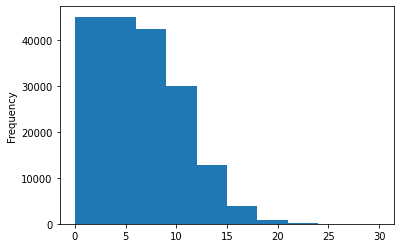

In [90]:
# Check the distribution of "line_number" column
train_df.line_number.plot.hist()

In [91]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column
train_line_numbers_one_hot=tf.one_hot(train_df["line_number"].to_numpy(),depth=15)
val_line_numbers_one_hot=tf.one_hot(val_df["line_number"].to_numpy(),depth=15)
test_line_numbers_one_hot=tf.one_hot(test_df["line_number"].to_numpy(),depth=15)
train_line_numbers_one_hot[:10],train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>, TensorShape([180040, 15]))

Now we've encoded our line numbers feature, let's do the same for our total lines feature...

In [92]:
# How many different numbers of lines  are there?
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

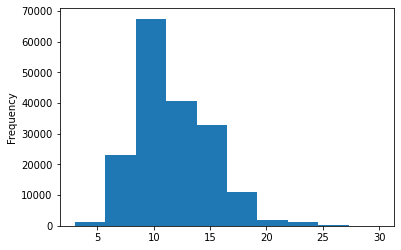

In [93]:
# Check the distributions of total lines
train_df.total_lines.plot.hist()

In [94]:
# Check the coverage of a "total_lines" value of 20
np.percentile(train_df.total_lines,98)

20.0

In [95]:
# Use Tensorflow to create one-hot-encoded-tensors of our "total_lines" feature
train_total_lines_one_hot=tf.one_hot(train_df["total_lines"].to_numpy(),depth=20)
val_total_lines_one_hot=tf.one_hot(val_df["total_lines"].to_numpy(),depth=20)
test_total_lines_one_hot=tf.one_hot(test_df["total_lines"].to_numpy(),depth=20)
train_total_lines_one_hot.shape,train_total_lines_one_hot[:10]

(TensorShape([180040, 20]), <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.

### Building a tribrid embedding model

1. Create a token-level model
2. Create a character-level model
3. Create a model for the "line_number" feature
4. Create a model for the "total_lines" feature
5. Combine the outputs 1 & 2 using tf.keras.layers.Concatenate
6. Combine the outputs of 3,4,5 using tf.keras.layers.Concatenate
7. Create an output layer to accept the tribrid embedding nad output label probabilities
8. Combine the inputs of 1,2,3,4 and outputs of 7 into a tf.keras.Model

In [96]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output, 
                                                                              char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

# 8. Put together model
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input, 
                                 char_model.input],
                         outputs=output_layer)

In [97]:
# Get a summary of our tribrid embedding model
model_5.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']     

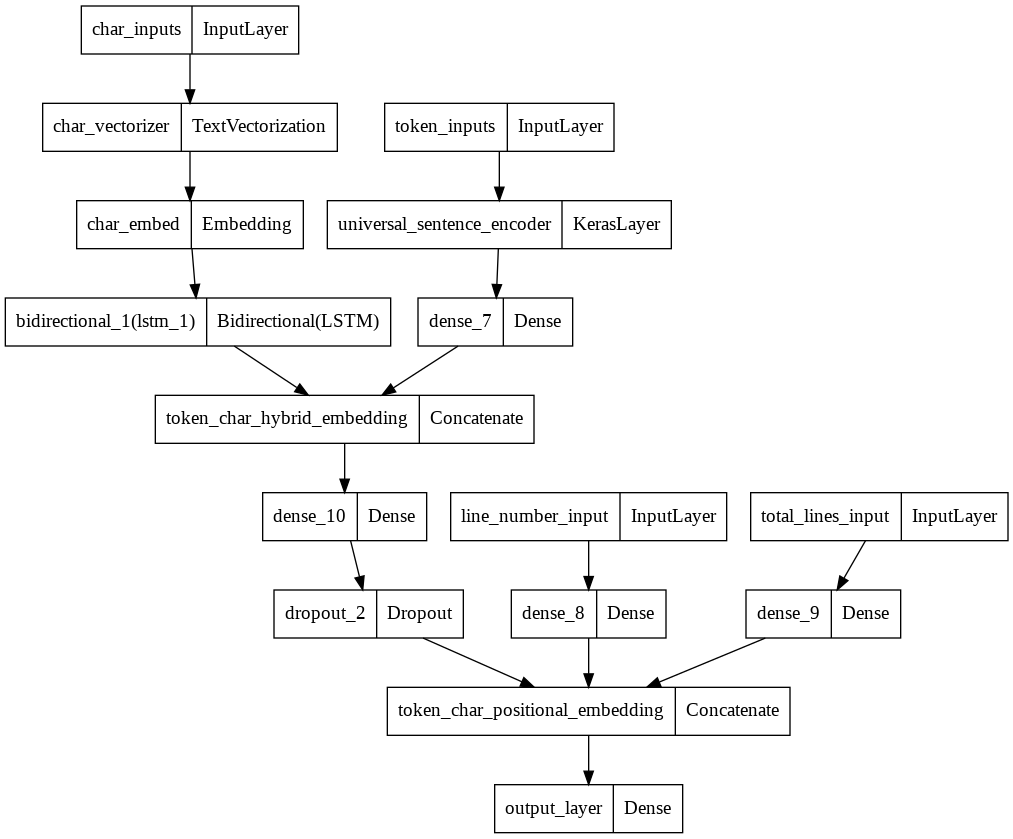

In [98]:
# plot model_5 to explore it visually...
from tensorflow.keras.utils import plot_model
plot_model(model_5)

What is label smoothing?

for example, if our model gets too confident on a simple class (e.g. its prediction probability is really high), it may get stuck on that class and not consider other classes...

Really confident: `[0.0, 0.0, 1.0, 0.0, 0.0]`

What label smoothing does is it assigns some of the values from the most highest pred prob to other classes, in turn, hopefully improving generalization: `[0.01, 0.01, 0.96, 0.01, 0.01]`

> 📖**Resource:** For more on label smoothing, see this blog post from  PyImageSearch: https://pyimagesearch.com/2019/12/30/label-smoothing-with-keras-tensorflow-and-deep-learning/

In [99]:
# Compile token, char, positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # add label smoothing (examples which are really confident get smoothed a little)
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### Create tribrid embedding datasets using tf.data

In [100]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting, evaluating and making predictions with our tribid model

In [101]:
# Fit the token, char and positional embedding model
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 37s 51ms/step - loss: 1.0918 - accuracy: 0.7303 - val_loss: 0.9779 - val_accuracy: 0.8065
Epoch 2/3
562/562 [==============================] - 26s 46ms/step - loss: 0.9656 - accuracy: 0.8176 - val_loss: 0.9506 - val_accuracy: 0.8278
Epoch 3/3
562/562 [==============================] - 24s 42ms/step - loss: 0.9504 - accuracy: 0.8230 - val_loss: 0.9395 - val_accuracy: 0.8298


In [102]:
# Make predictions with the char token pos model
model_5_pred_probs=model_5.predict(val_pos_char_token_dataset,verbose=1)
model_5_pred_probs

945/945 [==============================] - 23s 21ms/step


array([[0.4698362 , 0.12803492, 0.00911683, 0.37663522, 0.01637677],
       [0.5474696 , 0.10000607, 0.0365312 , 0.30623087, 0.00976222],
       [0.2576069 , 0.12596652, 0.11131072, 0.4390116 , 0.06610427],
       ...,
       [0.0329546 , 0.10742417, 0.03798371, 0.03161352, 0.79002404],
       [0.02959695, 0.3545127 , 0.08967355, 0.02546743, 0.5007494 ],
       [0.18901904, 0.5939229 , 0.11224996, 0.04028499, 0.06452303]],
      dtype=float32)

In [103]:
# Convert pred probs to pred labels
model_5_preds=tf.argmax(model_5_pred_probs,axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [104]:
# Calculate results of char token pos model
model_5_results=calculate_results(y_true=val_labels_encoded,
                                  y_pred=model_5_preds)
model_5_results

{'accuracy': 83.17224943730967,
 'precision': 0.8308557474439858,
 'recall': 0.8317224943730968,
 'f1': 0.8309455242846123}

### Compare model Results

In [105]:
# Combine mdoel result into a DataFrame
all_model_results=pd.DataFrame({"baseline":baseline_results,
                                "model_1_custom_token_embedding": model_1_results,
                                "model_2_pretrained_token_embedding": model_2_results,
                                "model_3_char_embedding":model_3_results,
                                "model_4_hybrid_char_token_embedding": model_4_results,
                                "model_5_pos_char_token_embedding": model_5_results})

all_model_results=all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,78.604528,0.782723,0.786045,0.783459
model_2_pretrained_token_embedding,71.425261,0.714731,0.714253,0.711339
model_3_char_embedding,65.553422,0.647881,0.655534,0.647881
model_4_hybrid_char_token_embedding,73.474116,0.734965,0.734741,0.732823
model_5_pos_char_token_embedding,83.172249,0.830856,0.831722,0.830946


In [106]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"]=all_model_results["accuracy"]/100

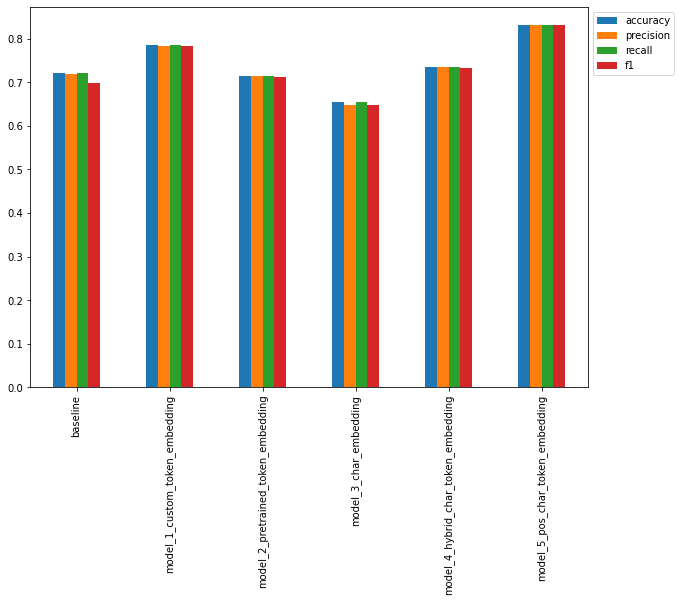

In [107]:
# Plot and compare all model results
all_model_results.plot(kind="bar",figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0))

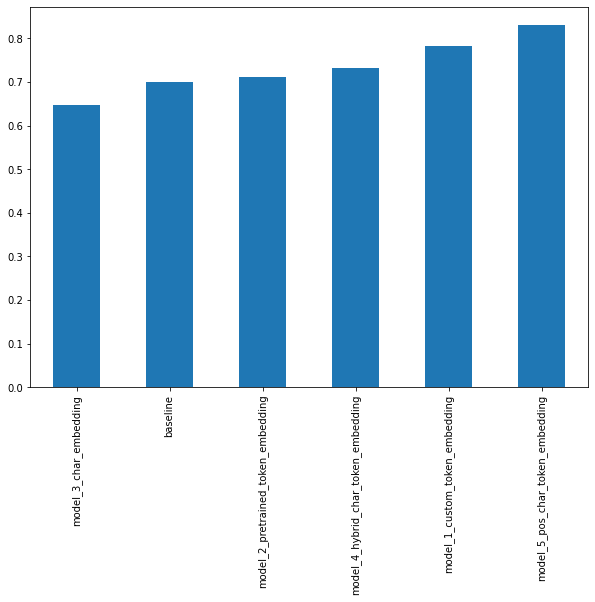

In [108]:
# Sort models results by f1-score
all_model_results.sort_values("f1",ascending=True)["f1"].plot(kind="bar",figsize=(10,7));

### Save and load model

In [109]:
# Save the best performing model to SavedModel format (default)
model_5.save("skimlit_tribrid_model")

In [110]:
# Load in best performing model
loaded_model=tf.keras.models.load_model("skimlit_tribrid_model")

In [111]:
# Make predictions with the loaded model on the validation set
loaded_pred_probs=loaded_model.predict(val_pos_char_token_dataset)
loaded_preds=tf.argmax(loaded_pred_probs,axis=1)
loaded_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])>

In [112]:
# calculate the t=results of our loaded model
loaded_model_results=calculate_results(y_true=val_labels_encoded,
                                       y_pred=model_5_preds)
loaded_model_results

{'accuracy': 83.17224943730967,
 'precision': 0.8308557474439858,
 'recall': 0.8317224943730968,
 'f1': 0.8309455242846123}

In [113]:
assert model_5_results==loaded_model_results

In [114]:
# Check the loaded model summary
loaded_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']     

### Your challenges

1. Turn the test data samples into a tf.data.Dataset (fast loading) and then evaluate (make predictions( the best performing model on the test samples.
2. Find the most most wrong predictions from 1 (these are the samples where the model has pretrained the wrong label with the highest prediction probability).
3. Make example predictions (on RCT abstracts from the wild). you can go to PubMed to fine these: https://pubmed.ncbi.nlm.nih.gov/, find and use our model to predict on 3-4 different abstract from the wild.
  * Some examples: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/skimlit_example_abstracts.json
4. See the execises and extra curriculum section on Github to further test your skils (for section 09)

### Challenge 1: Turn the test data samples into a tf.data.Dataset (fast loading) and then evaluate (make predictions( the best performing model on the test samples.

In [115]:
test_df.head()

,target,text,line_number,total_lines
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8
1,RESULTS,a post hoc analysis was conducted with the use...,1,8
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8
3,RESULTS,survival analyses were used to assess the asso...,3,8
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8


In [116]:
test_pos_char_token_data=tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                            test_total_lines_one_hot,
                                                            test_sentences,
                                                            test_chars))
test_pos_char_token_labels=tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset=tf.data.Dataset.zip((test_pos_char_token_data,test_pos_char_token_labels))
test_pos_char_token_dataset=test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [117]:
Test_pred_probs=model_5.predict(test_pos_char_token_dataset)
Test_pred_probs

array([[0.35481623, 0.07664272, 0.03972505, 0.47261164, 0.05620432],
       [0.33859137, 0.06411668, 0.23450375, 0.32304326, 0.03974494],
       [0.06742556, 0.02609124, 0.774059  , 0.08810303, 0.04432128],
       ...,
       [0.08192478, 0.10702343, 0.08335587, 0.07076958, 0.65692633],
       [0.0737934 , 0.09097586, 0.08741585, 0.05833004, 0.6894849 ],
       [0.08203641, 0.60965425, 0.11602342, 0.05811345, 0.13417242]],
      dtype=float32)

In [118]:
Test_preds=tf.squeeze(tf.argmax(Test_pred_probs,axis=1))
Test_preds

<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([3, 0, 2, ..., 4, 4, 1])>

In [119]:
Test_results=calculate_results(y_true=test_labels_encoded,
                               y_pred=Test_preds)
Test_results

{'accuracy': 82.65140202422432,
 'precision': 0.8255508761964309,
 'recall': 0.8265140202422432,
 'f1': 0.8256273340474461}

### Challenge 2: Find the most most wrong predictions from 1 (these are the samples where the model has pretrained the wrong label with the highest prediction probability).

In [120]:
Test_pred_probs.shape

(30135, 5)

In [121]:
test_df=pd.DataFrame({"Text": test_sentences,
                      "Target": test_labels_encoded,
                      "Predictions": Test_preds})

test_df["Pred_probs"]=tf.reduce_max(Test_pred_probs,axis=1)
test_df["Correct"]=test_df["Target"]==test_df["Predictions"]

test_df.head()

,Text,Target,Predictions,Pred_probs,Correct
0,this study analyzed liver function abnormaliti...,0,3,0.472612,False
1,a post hoc analysis was conducted with the use...,4,0,0.338591,False
2,liver function tests ( lfts ) were measured at...,4,2,0.774059,False
3,survival analyses were used to assess the asso...,4,2,0.647064,False
4,the percentage of patients with abnormal lfts ...,4,4,0.725502,True


In [122]:
most_wrong_predictions=test_df[test_df["Target"]!=test_df["Predictions"]]
most_wrong_predictions[:10]

,Text,Target,Predictions,Pred_probs,Correct
0,this study analyzed liver function abnormaliti...,0,3,0.472612,False
1,a post hoc analysis was conducted with the use...,4,0,0.338591,False
2,liver function tests ( lfts ) were measured at...,4,2,0.774059,False
3,survival analyses were used to assess the asso...,4,2,0.647064,False
8,elevated meld-xi scores are associated with po...,1,4,0.462807,False
10,the aim of this study was to analyse the cost-...,0,3,0.497479,False
20,nor was evar superior regarding cost-utility .,4,1,0.603818,False
22,evidence suggests that individuals with social...,0,3,0.502475,False
23,this study investigated whether oxytocin can a...,2,3,0.582474,False
29,the biological mechanisms by which oxytocin ma...,4,1,0.707948,False


In [123]:
wrong_predictions=test_df[test_df["Correct"]==False].sort_values("Pred_probs",ascending=False)
wrong_predictions

,Text,Target,Predictions,Pred_probs,Correct
13874,symptom outcomes will be assessed and estimate...,1,2,0.959235,False
8545,pretest-posttest .,2,0,0.930622,False
16347,to evaluate the effects of the lactic acid bac...,0,3,0.928781,False
1827,nct@ ( clinicaltrials.gov ) .,1,0,0.925344,False
2388,the primary endpoint is the cumulative three-y...,4,2,0.923431,False
...,...,...,...,...,...
1319,the authors identified @ patients ( @ % of the...,4,2,0.247609,False
23020,"overall , there were improvements in risk fact...",0,3,0.246300,False
16216,the formative research suggested that rdts wer...,4,1,0.242894,False
17958,the aim of this study is to determine whether ...,0,1,0.242354,False


In [124]:
# Investigate top wrong preds
for row in wrong_predictions[0:10].itertuples(): # adjust indexes to view different samples
  _, target, text, Predictions, Pred_probs, _ = row
  print(f"Target: {target}, Pred: {Predictions}, Prob: {Pred_probs}\n")
  print(f"Text:\n{text}\n")
  print("-----\n")

Target: symptom outcomes will be assessed and estimates of cost-effectiveness made ., Pred: 2, Prob: 0.9592347741127014

Text:
1

-----

Target: pretest-posttest ., Pred: 0, Prob: 0.9306219816207886

Text:
2

-----

Target: to evaluate the effects of the lactic acid bacterium lactobacillus salivarius on caries risk factors ., Pred: 3, Prob: 0.9287810325622559

Text:
0

-----

Target: nct@ ( clinicaltrials.gov ) ., Pred: 0, Prob: 0.925343930721283

Text:
1

-----

Target: the primary endpoint is the cumulative three-year hiv incidence ., Pred: 2, Prob: 0.9234308004379272

Text:
4

-----

Target: a cluster randomised trial was implemented with @,@ children in @ government primary schools on the south coast of kenya in @-@ ., Pred: 2, Prob: 0.9201636910438538

Text:
4

-----

Target: -@ % vs. fish : -@ % vs. fish + s : -@ % ; p < @ ) but there were no significant differences between groups ., Pred: 4, Prob: 0.9123939275741577

Text:
2

-----

Target: to validate the association between ac